## Method
*Similar to experiment_10_2 but add MSE measure
- Define a common region (rectangular based on city polygon bounds) to train subsets in all DB. This approach will allow to compute the prediction maps over different DB.
- Make prediction for city level using SEPP simplified (SEPPexp) using different DB.
- Compare models performance using hit rate, PAI and MSE. NOTE: coverage compute should be modified to consider the real city coverage (a % coverage over the rectangular region its bigger -much more cells- than the actual coverage over the city polygon).

## Hypothesis:
MSE between prediction and ground truth maps is lower for SIEDCO unimodal scenario.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import geojson
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from pyproj import Proj, transform
import pickle
import open_cp

In [2]:
from services import prediction_metrics
from services.prediction_experiment import PredictionExperiment
from services.process_data import ProcessData

Failed to import `rtree`.
Failed to import `rtree`.


## Built-in

In [3]:
def get_hit_rate_from_dict(row,column,coverage):
    return row[column][coverage]

In [4]:
def rectangular_region_projection(polygon, inProj, outProj):
    minx, miny, maxx, maxy = polygon.bounds
    # swap x,y as mkennedy says
    y1,x1 =  (miny, minx)
    point1=transform(inProj,outProj,x1,y1)
    x1, y1 = point1

    y2,x2 = (maxy, maxx)
    point2 = transform(inProj,outProj,x2,y2)
    x2, y2 = point2
    
    return open_cp.RectangularRegion(xmin=x1, xmax=x2, ymin=y1, ymax=y2)

## City region

In [5]:
geojson_bogota_file="/Users/anamaria/Desktop/dev/security_project/assets/bogota_polygon.geojson"
geojson_localidad_file="/Users/anamaria/Desktop/dev/security_project/assets/localidades_polygon.json"

with open(geojson_bogota_file) as f:
    geojson_bogota = geojson.load(f)

In [6]:
list_coords =list(map(lambda x: tuple(x), geojson_bogota['features'][0]['geometry']['coordinates'][0]))
bogota_polygon = Polygon(list_coords)

In [7]:
inProj  = Proj("+init=EPSG:4326",preserve_units=True) # WGS84 in degrees and not EPSG:3857 in meters)
outProj = Proj("+init=EPSG:3116") 
city_rectangular_region = rectangular_region_projection(bogota_polygon, inProj, outProj)

In [8]:
city_rectangular_region

RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )

#### Real percentage of city coverage over rectangular region (based on script experiment_11_1_get_rectangular_city_region):

In [9]:
city_percentage_on_region = 0.26

## Experimental design

In [10]:
train_dates = {'initial':'2018-09-01','final':'2018-09-30'}
validation_dates = {'initial':'2018-10-01','final':'2018-10-07'}
metrics = ''
aggregation = ''
filter_localidad = {'field':'','value':''}
model = "SEPPexp"
region = city_rectangular_region

## SIEDCO

In [10]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/deduplicate_siedco_09062020.csv'
siedco_info = {'name':'SIEDCO','path':csv_path}

In [11]:
city_experiment = PredictionExperiment(dataset_info=siedco_info, custom_filter=filter_localidad,train_dates=train_dates, validation_dates=validation_dates, model=model,metrics='',aggregation_data='')
prediction_array = city_experiment.run_ncv_experiment_region(time_unit='',grid_size=150, region=city_rectangular_region)

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (32,44) have mixed types. Specify dtype option on import or set low_memory=False.
  


train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 9, 30, 0, 0)}
current_validation_date 2018-10-01 00:00:00
[ 988807.62639539  998594.44292619 1001672.10473512 ... 1003737.05544376
  989213.46273198  992927.56105605] [1005904.29939307  995434.04879562 1006429.32950652 ... 1018668.9172931
 1002011.00890982 1000809.41090903]
RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/open_cp/seppexp.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  omega = _np.sum(upper_trianglar_sums) / _np.sum(weighted_upper_trianglar_sums)


omega: 0.4389183744859819, theta: 0.008766799133531802
1940
[ 997232.89277653 1000508.77007568  989362.1108524  1000591.95998426
  995291.56544137 1001630.10931021  995639.43527342  994676.67874019
  988307.50720377  986916.48270134 1000590.76947726  991491.42478173
  989401.1557639   998726.57299571  991187.78968395 1002827.47329914
  990437.47574636  997569.18871625  997746.56321629 1000136.0987807
  993545.40634077 1000575.82376664  999948.26379688  996741.84871764
  998614.76691699  999462.63671103  996222.47949211  987422.83181588
 1001152.18651771  998252.45296111  993056.76436045  999900.60729682
  993000.55478334  997685.78293646 1000630.91159784 1004850.3805687
  992096.61100211  997737.7044096   997875.19491232  996840.7892674
  993001.71676032] [1013339.63975503 1001759.67787564 1001761.59418831 1001193.91691818
  991223.36068562 1007162.13487877  989759.83964739 1003433.62721737
 1001835.67330212 1004971.73814297 1001194.50819931 1009476.49597905
 1002164.25381818 1001032.7

[ 997749.56812254  995892.06870478 1001164.33307656  992573.04067208
  991009.80232337  998557.76764203 1002669.03886479  991744.55141212
  992792.19045481  995826.277522    991771.03122144 1002400.91896231
  991830.28563231  997571.49036849 1000628.67995886 1001971.3892773
  995736.82020979  990188.06281007  998405.94333489  999807.9942831
  999811.92957681 1001038.74481973  999805.6207038  1001296.00282
  992879.29239908  996798.96464209  998826.39350153  987422.48270103
  986865.87568648 1000871.31019905  993473.27655317  999234.4973452
  990307.25011469  987483.76810793  991907.83157704  993986.82361072
  998910.92305841  994545.28578165  996918.72005285  998734.05830642
 1000627.71549191  992679.7358502 ] [ 997530.44821672  993593.20093265 1004524.94503086  994546.12920497
  995064.66032331 1013776.09294587 1017031.06268065 1006092.7528812
  995499.65889658 1016447.70644713 1003048.82491966 1006713.17333201
 1004598.58050271 1000215.98956324 1001387.97471738 1015632.41967452
  995

[1001120.05127709 1000160.8722513  1003781.69546909  995117.25994971
  995381.75763209 1000369.27695935  986408.32833741  998417.37841094
  992679.7358502  1000405.61023218  989770.07889384  991297.74675948
  986386.05895663  991175.5668402  1000165.63423048  995362.202401
  998134.26564854  998483.79641392  986584.96752023  998922.63473048
  998235.21650544  998095.32423583  995678.60333721  991995.13090947
  999685.99047885  995132.25443397  995219.18904882 1003355.38075442
  998278.21023141  998834.89507284  991157.4599584   991818.76921495
  996589.43192082 1002704.64605133  986740.47608511 1001695.91491445
  995736.11199652 1001647.06231305  997374.95195925  998365.38406008
  995738.3834158   999046.79640301  995930.20876539  992692.52822902
  992679.4381607   997433.39010761  992540.51279893  994231.59524018
  987409.44458831  994481.7796228   996400.52736773 1001259.92816323
  990786.86763258  993349.04458981  993365.20942851  997363.21999832
  996660.89307865  995439.14370737  

[1000629.26100301  988156.31818096  992679.43818787  990597.96111613
  991349.95042762  998134.0180533   992679.7358502   995787.27062622
  996757.76719776 1006638.02558091  997271.74513863  994594.24426443
  989190.38888461  988522.46350465  988320.76006767  989345.23759708
  988748.86028534  990035.58474917  997337.0824974   987811.18348711
  986638.80270079  998856.06437007  993126.22052391  996917.21705919
 1000566.68371321  999826.72971607  992248.54344841  998823.18627921
  990361.31549948  995524.4221325   987299.12007512 1000569.37100966
  997740.47279738 1000576.93327149  986534.63497707  992309.00546154
  990425.06371249  997936.75664687  994014.81517591  999921.50608801
  995745.37369393  993491.44186165  999100.02753187 1002342.66809675
  988454.85105108  990001.58989958  992566.74592346  993114.1433626
  992123.23638181  993528.78373428 1000941.5095679   996667.46868969
  997171.87240122  990197.95893747  994906.00133833  995049.09467128
  996776.4336957   994895.49449252 

[ 995490.86736249  992520.84928228  990594.77637472  987839.98863535
  990063.09661227  994253.77287314  999442.23198645 1002362.60743869
  996378.87926447  995340.04145299  996656.79242534  994890.89773529
 1006310.50276011 1000817.5440878   993446.62737897  990978.08211482
  999992.66807526 1000667.68923121  991268.58255779 1004661.07158381
  998907.33438816  995517.79468159  989762.78648724  993129.92166718
  994452.03218119  988953.24663778  990773.67844309  998929.39244465
  995515.25129764  995103.37282162  998170.20309667  993445.22555066
 1001764.51904085 1006107.29970167  992320.58842427  990045.28834971
  993289.15674446  996009.95516195  993718.65485648 1000760.12009149
  996125.48969533  998271.36123075 1000097.4808873   995015.46445964
  987667.49488265  998609.26153498 1000144.86785564  995420.78932891
  992861.09176062  998043.11858418  998741.3174924   990999.55415705
 1005270.58851744  990795.63219454 1003319.347671    990154.55429582
  995041.60907302  992679.43818787

train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 6, 0, 0)}
current_validation_date 2018-10-07 00:00:00
[ 988807.62639539  998594.44292619 1001672.10473512 ...  991591.82071743
  996120.17374906  992679.7358502 ] [1005904.29939307  995434.04879562 1006429.32950652 ... 1010794.11653265
  997431.25920242  997967.95006148]
RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )
omega: 0.4252529427450744, theta: 0.009437558117693994
2262
[ 996845.60469369  994612.03463782  993322.99705958  993793.8798135
  993389.49591287  990294.00016325  993893.60957897 1002513.68851437
  996258.35797483  998476.14042051 1003775.06906993  994416.4634046
 1000970.30393607  997780.85570327  998563.99392535  989204.85132181
  989163.8290545   998109.59087358 1000634.10269792  991430.48369597
  994867.65767235  988917.98780014  998719.39892515  998452.53209404
  991788.31006316 1000297.32022722  991151.636776

[ 996845.60469369  994612.03463782  993322.99705958  993793.8798135
  993389.49591287  990294.00016325  993893.60957897 1002513.68851437
  996258.35797483  998476.14042051 1003775.06906993  994416.4634046
 1000970.30393607  997780.85570327  998563.99392535  989204.85132181
  989163.8290545   998109.59087358 1000634.10269792  991430.48369597
  994867.65767235  988917.98780014  998719.39892515  998452.53209404
  991788.31006316 1000297.32022722  991151.6367762   998655.01773717
  990028.56963378  994835.68542788  998953.42739066  987964.15778321
 1003035.57057978  989384.73341892  997659.41748875  998560.14208493
  992795.94440822  993520.71653584  988796.99120735  995684.22743982
  993117.03520795  998642.02615171  998865.5832231   993501.30903383
  989142.86647058 1005896.97622228  997645.59630565  991174.78014434
  999234.95667451  993604.06480352  986724.22349191 1002564.43407061
  999008.6976249   988462.0507295   998499.64221428  994138.43907479
  991827.74685079 1003744.40372304  

In [12]:
df_siedco = pd.DataFrame(prediction_array, columns =['initial-date','final-date','prediction','eval_pts'])

## RNMC

In [10]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/06. verify_enrich_rnmc_12022020.csv'
rnmc_info = {'name':'RNMC','path':csv_path}

In [11]:
city_experiment = PredictionExperiment(dataset_info=rnmc_info, custom_filter=filter_localidad,train_dates=train_dates, validation_dates=validation_dates, model=model,metrics='',aggregation_data='')
prediction_array = city_experiment.run_ncv_experiment_region(time_unit='',grid_size=150, region=city_rectangular_region)


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  


train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 9, 30, 0, 0)}
current_validation_date 2018-10-01 00:00:00
RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )
omega: 0.012196032836491828, theta: 0.02704448512864927
12325
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 1, 0, 0)}
current_validation_date 2018-10-02 00:00:00
RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )
omega: 0.011973448563131496, theta: 0.027927183461081924
12603
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 2, 0, 0)}
current_validation_date 2018-10-03 00:00:00
RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )
omega: 0.012161494414636383, theta: 0.02855924255426935
12936
train_subset_dates {'initial':

In [12]:
df_rnmc = pd.DataFrame(prediction_array, columns =['initial-date','final-date','prediction','eval_pts'])

## NUSE

In [16]:
csv_path = '/Users/anamaria/Desktop/dev/security_project/datasets/06. verify_enrich_nuse_11022020.csv'
nuse_info = {'name':'NUSE','path':csv_path}

In [17]:
city_experiment = PredictionExperiment(dataset_info=nuse_info, custom_filter=filter_localidad,train_dates=train_dates, validation_dates=validation_dates, model=model,metrics='',aggregation_data='')
prediction_array = city_experiment.run_ncv_experiment_region(time_unit='',grid_size=150, region=city_rectangular_region)


/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  


train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 9, 30, 0, 0)}
current_validation_date 2018-10-01 00:00:00
RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )
omega: 0.01338370806891366, theta: 0.046533962681121005
32842
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 1, 0, 0)}
current_validation_date 2018-10-02 00:00:00
RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )
omega: 0.013366049162129025, theta: 0.046687957343877436
33695
train_subset_dates {'initial': datetime.datetime(2018, 9, 1, 0, 0), 'final': datetime.datetime(2018, 10, 2, 0, 0)}
current_validation_date 2018-10-03 00:00:00
RectangularRegion( (958645.8182116302,904338.0678953262) -> (1010091.3509687895,1026604.2846545206) )
omega: 0.013233538183621472, theta: 0.046892410866271154
34539
train_subset_dates {'initial'

In [18]:
df_nuse = pd.DataFrame(prediction_array, columns =['initial-date','final-date','prediction','eval_pts'])

## Save prediction results

In [12]:
path='/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/'

In [19]:
ProcessData.save_element(path, 'experiment_seppexp_10_2_siedco_prediction', df_siedco)
ProcessData.save_element(path, 'experiment_seppexp_10_2_rnmc_prediction', df_rnmc)
ProcessData.save_element(path, 'experiment_seppexp_10_2_nuse_prediction', df_nuse)

## Measure hit rate, PAI and MSE

In [11]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_siedco_prediction.pkl','rb')
loaded_siedco = pickle.load(infile)
infile.close()

In [12]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_rnmc_prediction.pkl','rb')
loaded_rnmc = pickle.load(infile)
infile.close()

In [13]:
infile = open('/Users/anamaria/Desktop/dev/security_project/aggressive_behavior_model/pkl/experiment_seppexp_10_2_nuse_prediction.pkl','rb')
loaded_nuse = pickle.load(infile)
infile.close()

In [14]:
## coverages are represented in % (NOT IN PROPORTION)
coverages = [2,4,6,8,10,12,14,16,18,20]
### this approach is only used to open_cp hit rate implementation method makes sense
real_coverages_city = list(map(lambda c: round((c/100)*city_percentage_on_region*100, 1), coverages))

In [15]:
## coverages are represented in % (NOT IN PROPORTION)
real_coverages_city

[0.5, 1.0, 1.6, 2.1, 2.6, 3.1, 3.6, 4.2, 4.7, 5.2]

### SIEDCO

In [16]:
df_result = loaded_siedco.copy()

In [17]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [18]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [19]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [20]:
## MSE
df_result['MSE'] = df_result.apply(lambda row: prediction_metrics.mse(row['prediction'],row['eval_pts']), axis=1)

In [21]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

coverage_TP                       0.020564
hit_rate_TP                       0.049111
PAI_TP                          298.142997
hit_rate_default_coverage_2       0.228779
PAI_default_coverage_2           11.438935
hit_rate_default_coverage_4       0.299391
PAI_default_coverage_4            7.484769
hit_rate_default_coverage_6       0.299391
PAI_default_coverage_6            4.989846
hit_rate_default_coverage_8       0.299391
PAI_default_coverage_8            3.742385
hit_rate_default_coverage_10      0.299391
PAI_default_coverage_10           2.993908
hit_rate_default_coverage_12      0.299391
PAI_default_coverage_12           2.494923
hit_rate_default_coverage_14      0.299391
PAI_default_coverage_14           2.138505
hit_rate_default_coverage_16      0.299391
PAI_default_coverage_16           1.871192
hit_rate_default_coverage_18      0.299391
PAI_default_coverage_18           1.663282
hit_rate_default_coverage_20      0.299391
PAI_default_coverage_20           1.496954
MSE        

### RNMC

In [22]:
df_result = loaded_rnmc.copy()

In [23]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [24]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [25]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [26]:
## MSE
df_result['MSE'] = df_result.apply(lambda row: prediction_metrics.mse(row['prediction'],row['eval_pts']), axis=1)

In [27]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

coverage_TP                       0.124019
hit_rate_TP                       0.133222
PAI_TP                          108.963108
hit_rate_default_coverage_2       0.518141
PAI_default_coverage_2           25.907043
hit_rate_default_coverage_4       0.662509
PAI_default_coverage_4           16.562716
hit_rate_default_coverage_6       0.755519
PAI_default_coverage_6           12.591988
hit_rate_default_coverage_8       0.804676
PAI_default_coverage_8           10.058450
hit_rate_default_coverage_10      0.804676
PAI_default_coverage_10           8.046760
hit_rate_default_coverage_12      0.804676
PAI_default_coverage_12           6.705633
hit_rate_default_coverage_14      0.804676
PAI_default_coverage_14           5.747686
hit_rate_default_coverage_16      0.804676
PAI_default_coverage_16           5.029225
hit_rate_default_coverage_18      0.804676
PAI_default_coverage_18           4.470422
hit_rate_default_coverage_20      0.804676
PAI_default_coverage_20           4.023380
MSE        

### NUSE

In [28]:
df_result = loaded_nuse.copy()

In [29]:
df_result['hitrate_default'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],real_coverages_city,'default'), axis=1)
df_result['hitrate_TP'] = df_result.apply(lambda row: prediction_metrics.measure_hit_rates(row['prediction'],row['eval_pts'],real_coverages_city,'ground_truth_coverage'), axis=1)


In [30]:
##For hitrate_TP "true positives"
df_result['coverage_TP'] = df_result.apply(lambda row: (list(row['hitrate_TP'].keys())[0])/city_percentage_on_region, axis=1)
df_result['hit_rate_TP'] = df_result.apply(lambda row: list(row['hitrate_TP'].values())[0], axis=1)
df_result['PAI_TP'] = df_result['hit_rate_TP'] / (df_result['coverage_TP']/100)

In [31]:
##For hitrate_default
#coverages = [2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0]
column_dict = 'hitrate_default'
for c in real_coverages_city:
    new_hit_rate_column = 'hit_rate_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_hit_rate_column] = df_result.apply(lambda row: get_hit_rate_from_dict(row,column_dict,c), axis=1)

    ##PAI
    new_column = 'PAI_default_coverage_'+str(round(c/city_percentage_on_region))
    df_result[new_column] = df_result[new_hit_rate_column]/(round(c/city_percentage_on_region)/100)


In [32]:
## MSE
df_result['MSE'] = df_result.apply(lambda row: prediction_metrics.mse(row['prediction'],row['eval_pts']), axis=1)

In [33]:
#delete datetimes where no crimes were reported (0 crimes on ground truth -> hit-rate = -1)
df_result = df_result[df_result['hit_rate_default_coverage_2']!= -1]
print(df_result.mean())

coverage_TP                      0.365678
hit_rate_TP                      0.155397
PAI_TP                          48.633940
hit_rate_default_coverage_2      0.371721
PAI_default_coverage_2          18.586058
hit_rate_default_coverage_4      0.543793
PAI_default_coverage_4          13.594828
hit_rate_default_coverage_6      0.694170
PAI_default_coverage_6          11.569497
hit_rate_default_coverage_8      0.785099
PAI_default_coverage_8           9.813744
hit_rate_default_coverage_10     0.853635
PAI_default_coverage_10          8.536345
hit_rate_default_coverage_12     0.909905
PAI_default_coverage_12          7.582541
hit_rate_default_coverage_14     0.920220
PAI_default_coverage_14          6.572999
hit_rate_default_coverage_16     0.920220
PAI_default_coverage_16          5.751374
hit_rate_default_coverage_18     0.920220
PAI_default_coverage_18          5.112332
hit_rate_default_coverage_20     0.920220
PAI_default_coverage_20          4.601099
MSE                              0

## MSE summary results

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x123cc6940>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x126b841d0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x126b84208>] instances.
A proxy artist may be used instead.
See: http:/

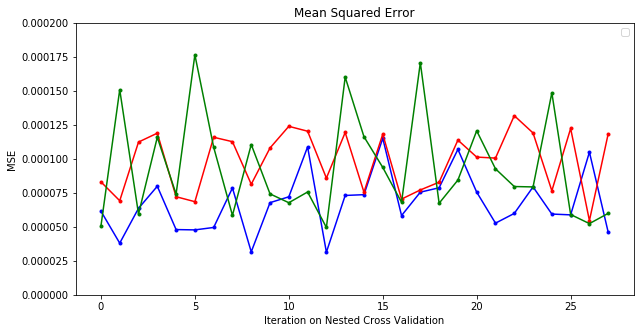

In [49]:
df_siedco = loaded_siedco.copy()
df_siedco['MSE'] = df_siedco.apply(lambda row: prediction_metrics.mse(row['prediction'],row['eval_pts']), axis=1)
df_rnmc = loaded_rnmc.copy()
df_rnmc['MSE'] = df_rnmc.apply(lambda row: prediction_metrics.mse(row['prediction'],row['eval_pts']), axis=1)
df_nuse = loaded_nuse.copy()
df_nuse['MSE'] = df_nuse.apply(lambda row: prediction_metrics.mse(row['prediction'],row['eval_pts']), axis=1)

fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.plot(df_siedco.index.values, df_siedco['MSE'].values, marker=".",color='blue')
rnmc = ax.plot(df_rnmc.index.values, df_rnmc['MSE'].values, marker=".",color='red')
nuse = ax.plot(df_nuse.index.values, df_nuse['MSE'].values, marker=".",color='green')
#multimodal_average = ax.scatter(result.index.values,result['multimodal_average_entropy'].values, marker=".",color='orange')
#multimodal_max = ax.scatter(result.index.values,result['multimodal_max_entropy'].values, marker=".",color='blue')
#multimodal_max_cell = ax.scatter(result.index.values,result['multimodal_max_cell_entropy'].values, marker=".",color='black')
ax.set_title('Mean Squared Error')
ax.set_ylim(0,0.00020)
ax.legend((siedco, rnmc, nuse),('siedco', 'rnmc', 'nuse'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel('MSE')
plt.show()

In [1]:
## To check if normalized matrices influence the MSE value (MSE interpretation should be done
# between scenarios). Might not be appropiated to interpret the result as a MSE close to 0 (
# a value close to 0 in this case doesn't necessary mean that both matrices are very similar)

In [55]:
import sklearn
from sklearn.metrics import mean_squared_error

def mse_2(grid_pred, real_events):
    """ Computes the "mean aquared error" between the prediction and the ground
        truth. Is computed as the sum of each cell squared difference.

    :param grid_pred: An instance of :class:`GridPrediction` matrix attribute
                      must be normalized.
    :param real_events: An instance of :class: open_cp.data.TimedPoints

    :return: A non-negative floating point value
    """
    grid_pred._matrix = ProcessData.normalize_matrix(grid_pred._matrix)
    counting_matrix = prediction_metrics.make_counting_grid(grid_pred, real_events)
    counting_matrix._matrix = ProcessData.normalize_matrix(counting_matrix._matrix)
    return mean_squared_error(grid_pred._matrix*100, counting_matrix._matrix*100)

/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x126a12320>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x12655e6a0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/Users/anamaria/Desktop/dev/security_project/security_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x12655e5f8>] instances.
A proxy artist may be used instead.
See: http:/

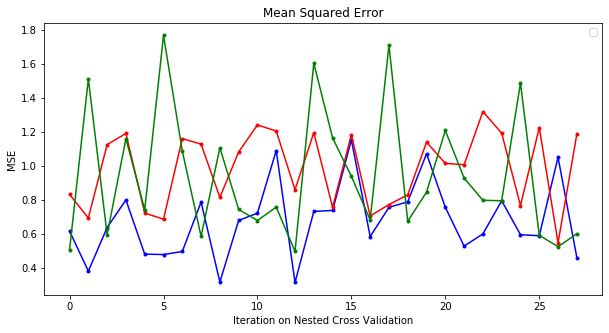

In [56]:
df_siedco = loaded_siedco.copy()
df_siedco['MSE'] = df_siedco.apply(lambda row: mse_2(row['prediction'],row['eval_pts']), axis=1)
df_rnmc = loaded_rnmc.copy()
df_rnmc['MSE'] = df_rnmc.apply(lambda row: mse_2(row['prediction'],row['eval_pts']), axis=1)
df_nuse = loaded_nuse.copy()
df_nuse['MSE'] = df_nuse.apply(lambda row: mse_2(row['prediction'],row['eval_pts']), axis=1)

fig, ax = plt.subplots(figsize=(10,5))
siedco = ax.plot(df_siedco.index.values, df_siedco['MSE'].values, marker=".",color='blue')
rnmc = ax.plot(df_rnmc.index.values, df_rnmc['MSE'].values, marker=".",color='red')
nuse = ax.plot(df_nuse.index.values, df_nuse['MSE'].values, marker=".",color='green')
#multimodal_average = ax.scatter(result.index.values,result['multimodal_average_entropy'].values, marker=".",color='orange')
#multimodal_max = ax.scatter(result.index.values,result['multimodal_max_entropy'].values, marker=".",color='blue')
#multimodal_max_cell = ax.scatter(result.index.values,result['multimodal_max_cell_entropy'].values, marker=".",color='black')
ax.set_title('Mean Squared Error')
#ax.set_ylim(0,0.00020)
ax.legend((siedco, rnmc, nuse),('siedco', 'rnmc', 'nuse'))
plt.xlabel('Iteration on Nested Cross Validation')
plt.ylabel('MSE')
plt.show()